In [11]:
import os
import glob
import numpy as np
import pandas as pd
import obspy
from obspy import Stream, read, read_inventory, Inventory

%reload_ext autoreload
%autoreload 2
from classes_functions.NCEDC_files_converter import NCEDC_HypoInverse_reader
nyhypoinv = NCEDC_HypoInverse_reader()

ncedc_pick_dir = '../data/NCEDC_picks'

file_list = [f'{year}.txt' for year in range(2008, 2024)]
print(file_list)

['2008.txt', '2009.txt', '2010.txt', '2011.txt', '2012.txt', '2013.txt', '2014.txt', '2015.txt', '2016.txt', '2017.txt', '2018.txt', '2019.txt', '2020.txt', '2021.txt', '2022.txt', '2023.txt']


# NCEDC picks to a Dictionary

In [12]:
# make a dictionary to store all the picks files into one
my_dict = {}
for file in file_list[:]:
  dict = nyhypoinv.NCEDC_picks_2_dict(ncedc_pick_dir, file)
  my_dict.update(dict)

print(len(list(my_dict.keys())))
print(list(my_dict.keys())[-10:])

for line in my_dict[list(my_dict.keys())[-1]]:
  print(line)
  break


7312
['nc73979931', 'nc73980066', 'nc73980546', 'nc73980711', 'nc73981126', 'nc73981181', 'nc73981716', 'nc73981981', 'nc73982056', 'nc73982061']
['nc73982061', '2023-12-28T12:03:26.22', 40.4025, 125.10833333333333, 10.0, 3.5, 'BG.AL1..DPZ', 'P', '', '2023-12-28T12:04:2.73']


In [13]:
my_dict.keys()

dict_keys(['nc51193680', 'nc71092841', 'nc71093761', 'nc71093956', 'nc51194589', 'nc51194666', 'nc51194828', 'nc71094821', 'nc71094841', 'nc51194903', 'nc40210243', 'nc71097255', 'nc71097490', 'nc51196020', 'nc51196113', 'nc51196118', 'nc51196162', 'nc71098266', 'nc71098481', 'nc71098521', 'nc71098536', 'nc51196287', 'nc51196290', 'nc71098916', 'nc71099431', 'nc51196619', 'nc71099831', 'nc51196707', 'nc51196872', 'nc71100711', 'nc71100926', 'nc71101161', 'nc51197150', 'nc51197189', 'nc71101376', 'nc71101426', 'nc71101441', 'nc51197306', 'nc71102256', 'nc71102321', 'nc51197503', 'nc51197677', 'nc51197782', 'nc71103341', 'nc71103406', 'nc71104386', 'nc71104416', 'nc71104916', 'nc71105426', 'nc51198711', 'nc51198748', 'nc51198749', 'nc51198805', 'nc51198810', 'nc71105801', 'nc51198962', 'nc51199002', 'nc71106261', 'nc51199107', 'nc71106556', 'nc71106981', 'nc51199341', 'nc51199432', 'nc71107456', 'nc51199526', 'nc71107596', 'nc71107796', 'nc40214530', 'nc71108070', 'nc40214567', 'nc711083

# Convert into a Dataframe 

In [14]:
master_df = nyhypoinv.picks_dict_to_df(my_dict)

# write to csv
master_df.to_csv(f'{ncedc_pick_dir}/NCEDC_picks_50km.csv', index=False)

print(master_df.shape)
master_df.head()

(253161, 10)


,event_id,etime,elat,elon,edep,emag,station_id,phase_type,phase_polarity,phase_time
0,nc51193680,2008-01-01 05:58:18.290,40.7805,-123.561333,20.32,2.04,BK.JCC..HHZ,P,1.0,2008-01-01 05:58:26.220
1,nc51193680,2008-01-01 05:58:18.290,40.7805,-123.561333,20.32,2.04,BK.WDC..HHZ,P,1.0,2008-01-01 05:58:33.060
2,nc51193680,2008-01-01 05:58:18.290,40.7805,-123.561333,20.32,2.04,NC.KBS..SHZ,P,-1.0,2008-01-01 05:58:34.270
3,nc51193680,2008-01-01 05:58:18.290,40.7805,-123.561333,20.32,2.04,NC.KCR..SHZ,P,1.0,2008-01-01 05:58:27.140
4,nc51193680,2008-01-01 05:58:18.290,40.7805,-123.561333,20.32,2.04,NC.KCS..SHZ,P,1.0,2008-01-01 05:58:24.930


# Make a Catalog

In [15]:
# extract events catalog from picks df
eq_df = master_df[
    ['event_id', 'etime', 'elat', 'elon', 'edep', 'emag']
    ].drop_duplicates(subset='event_id').reset_index(drop=True)

# write in USGS format
eq_df.columns = ['id', 'time', 'latitude', 'longitude', 'depth', 'mag']
eq_df.to_csv(
    f'{ncedc_pick_dir}/NCEDC_eq_cat_50km.csv', 
    index=False, header=False,
    float_format='%.4f'
)

print(eq_df.shape)
eq_df.head()

(7312, 6)


,id,time,latitude,longitude,depth,mag
0,nc51193680,2008-01-01 05:58:18.290,40.780500,-123.561333,20.32,2.04
1,nc71092841,2008-01-06 05:52:36.260,40.481667,-124.594000,20.24,2.44
2,nc71093761,2008-01-13 02:34:14.790,40.882667,-123.681667,11.23,2.23
3,nc71093956,2008-01-14 09:30:08.410,40.627333,-124.247333,13.45,1.81
4,nc51194589,2008-01-14 19:11:31.050,40.779833,-123.564000,22.51,2.50


# Above slab2 interface events

In [16]:
from scipy.interpolate import griddata

cat_folder = f"../data/eq_data/1_eq_catalogs"
# slab2_file = f"{cat_folder}/slab2_subset.csv"
slab2_nonan_file = f"{cat_folder}/slab2_subset_no_nan.csv"

# Load data
slab2_no_nan = pd.read_csv(slab2_nonan_file)

# intepolate slab depth to the earthquake locations
# and add the slab depth to the eq_df as a new column
eq_df['slab_depth'] = griddata(
    (slab2_no_nan['lon'], slab2_no_nan['lat']), 
    slab2_no_nan['depth'], 
    (eq_df['longitude'], eq_df['latitude']), method='linear'
    )

# select earthquakes with slab_depth column is not NaN
eq_in_slab2_area_df = eq_df[~np.isnan(eq_df['slab_depth'])] # ~ means not

# make slab_depth column positive because earthquake depth are also positive
eq_in_slab2_area_df.loc[:, 'slab_depth'] = -eq_in_slab2_area_df.slab_depth

# get above slab earthquakes i.e. eq depth < slab depth
above_slab_eq_df = eq_in_slab2_area_df[
    eq_in_slab2_area_df['depth'] < eq_in_slab2_area_df['slab_depth']
    ]

above_slab_eq_df.to_csv(f'{ncedc_pick_dir}/NCEDC_eq_cat_above_slab.csv', index=False)
above_slab_eq_df.head()

,id,time,latitude,longitude,depth,mag,slab_depth
0,nc51193680,2008-01-01 05:58:18.290,40.780500,-123.561333,20.32,2.04,27.507681
2,nc71093761,2008-01-13 02:34:14.790,40.882667,-123.681667,11.23,2.23,25.196133
3,nc71093956,2008-01-14 09:30:08.410,40.627333,-124.247333,13.45,1.81,15.225232
4,nc51194589,2008-01-14 19:11:31.050,40.779833,-123.564000,22.51,2.50,27.440600
5,nc51194666,2008-01-15 17:03:12.430,40.553333,-124.194500,10.27,2.28,16.031894


# Finally, convert into PyRocko format phase picks file
### Change command to create for entire data or year by year.

In [17]:
# select picks for above slab earthquakes
above_slab_picks_df = master_df[master_df['event_id'].isin(above_slab_eq_df['id'])]
above_slab_picks_df = above_slab_picks_df.sort_values(['etime', 'event_id']).reset_index(drop=True)
above_slab_picks_df.to_csv(f'{ncedc_pick_dir}/NCEDC_picks_above_slab.csv', index=False)

# group by year of the event
above_slab_picks_df['year'] = above_slab_picks_df['etime'].dt.year

for iyear, year_df in above_slab_picks_df.groupby('year'):
    
    year_df = year_df.drop(columns='year')
    year_df.to_csv(f'{ncedc_pick_dir}/{iyear}_NCEDC_picks_above_slab.csv', index=False)

    from classes_functions.NCEDC_files_converter import NCEDC_HypoInverse_reader
    nchypoinv = NCEDC_HypoInverse_reader()

    df = nchypoinv.df_to_pyrocko_marker(
        picks_df=year_df, 
        output_dir=ncedc_pick_dir, 
        file_name=f'{iyear}_NCEDC_picks_above_slab_pyrocko.txt'
    )
print(df[:1000])

# Snuffler Markers File Version 0.2
event: 2023-08-15 19:50:29.7000  0 NbrnTP3fAbnFbmOHnKYaXRvj7uf=   40.1428333 -123.8600000         21.82 1.57 None  nc71131214 None
phase: 2023-08-15 19:50:36.2000  0 BK.BLAS..HHZ     NbrnTP3fAbnFbmOHnKYaXRvj7uf= 2023-08-15 19:50:29.7000 P           nan False
phase: 2023-08-15 19:50:44.1800  0 BK.DLIK..HHZ     NbrnTP3fAbnFbmOHnKYaXRvj7uf= 2023-08-15 19:50:29.7000 P           nan False
phase: 2023-08-15 19:50:35.2700  0 BK.GHOP..HHZ     NbrnTP3fAbnFbmOHnKYaXRvj7uf= 2023-08-15 19:50:29.7000 P             1 False
phase: 2023-08-15 19:50:40.8500  0 BK.HUNT..HHZ     NbrnTP3fAbnFbmOHnKYaXRvj7uf= 2023-08-15 19:50:29.7000 P             1 False
phase: 2023-08-15 19:50:44.8600  0 BK.PETY..HHZ     NbrnTP3fAbnFbmOHnKYaXRvj7uf= 2023-08-15 19:50:29.7000 P            -1 False
phase: 2023-08-15 19:50:34.6300  0 BK.PRDS..HHZ     NbrnTP3fAbnFbmOHnKYaXRvj7uf= 2023-08-15 19:50:29.7000 P             1 False
phase: 2023-08-15 19:50:36.3400  0 BK.RBOW..HHZ     NbrnTP3fAbnFb

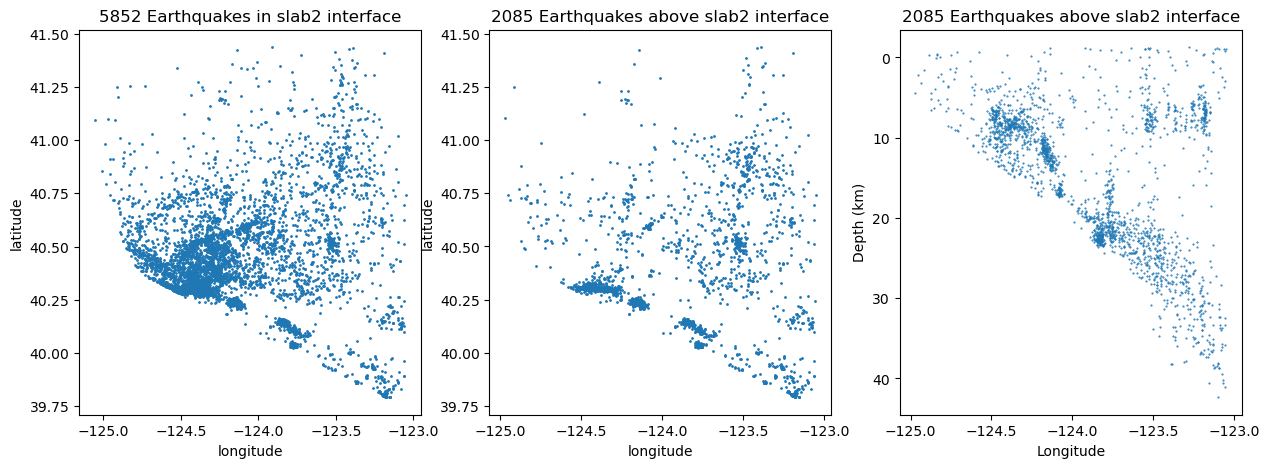

In [18]:
# plot
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
ax1, ax2, ax3 = axs

eq_in_slab2_area_df.plot.scatter(x='longitude', y='latitude', s=1, ax=ax1)
ax1.set_title(f'{eq_in_slab2_area_df.shape[0]} Earthquakes in slab2 interface')

above_slab_eq_df.plot.scatter(x='longitude', y='latitude', s=1, ax=ax2)
ax2.set_title(f'{above_slab_eq_df.shape[0]} Earthquakes above slab2 interface')

# cross section
ax3.plot(above_slab_eq_df['longitude'], above_slab_eq_df['depth'], '.', markersize=1)
ax3.invert_yaxis()
ax3.set_xlabel('Longitude'), ax3.set_ylabel('Depth (km)')
ax3.set_title(f'{above_slab_eq_df.shape[0]} Earthquakes above slab2 interface')

plt.show()